# Best Implementation on Subtask A: Validation
Last updated on 21/02/2022

#### Project Information:
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* By: Ilan
 
#### Task Description:
The subtask A is a validation task. The purpose is to determine which of two similar natural language statements is against common sense.

*Example:*  
> Task: Which of the two statements is against common sense?  
> Statement1: He put a turkey into the fridge.  
> Statement2: He put an elephant into the fridge. 

#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 


Please Note:  
1. In this implementation work, there is no validation process. Here, the validation dataset will be used as the training dataset to improve the performance of the best implementation.  
2. The optimal model and hyperparameters selected by the experiment require large storage (about 19G) on the GPU. If you just want to see how this implementation works, you can use a smaller model and batch size.

<!-- #### Task Description:
The subtask A is a validation task. The purpose is going to tell which of two similar natural language statements is against common sense.

*Example:* 
        
    Task: Which statement of the two is against common sense?
    Statement1: He put a turkey into the fridge.  
    Statement2: He put an elephant into the fridge.    -->

In [8]:
import os
my_file = "./DataSet"
if not os.path.exists(my_file):
  !unzip DataSet.zip

Archive:  DataSet.zip
   creating: DataSet/
   creating: DataSet/Dev Data/
  inflating: DataSet/Dev Data/subtaskA_dev_data.csv  
  inflating: DataSet/Dev Data/subtaskA_gold_answers.csv  
  inflating: DataSet/Dev Data/subtaskB_dev_data.csv  
  inflating: DataSet/Dev Data/subtaskB_gold_answers.csv  
  inflating: DataSet/Dev Data/subtaskC_dev_data.csv  
  inflating: DataSet/Dev Data/subtaskC_gold_answers.csv  
  inflating: DataSet/dev.csv         
   creating: DataSet/Test Data/
   creating: DataSet/Test Data/ExampleSubmission/
  inflating: DataSet/Test Data/ExampleSubmission/submission.zip  
  inflating: DataSet/Test Data/ExampleSubmission/subtaskA_answers.csv  
  inflating: DataSet/Test Data/ExampleSubmission/subtaskB_answers.csv  
  inflating: DataSet/Test Data/ExampleSubmission/subtaskC_answers.csv  
  inflating: DataSet/Test Data/subtaskA_gold_answers.csv  
  inflating: DataSet/Test Data/subtaskA_test_data.csv  
  inflating: DataSet/Test Data/subtaskB_gold_answers.csv  
  inflating: 

## 1. General Preparation

Import some common libraries.

In [2]:
from tqdm import tqdm
import time
!pip install transformers

Use GPU Facilities.

In [3]:
import torch
cuda_id = 0
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:0 - Tesla P100-PCIE-16GB


Set the model and hyperparameters for implementation.

In [4]:
# Best implementation
model_name = "roberta-large"
optimizer_name = 'Adam'
learning_rate = 1e-5
batch_size = 128
epoch = 15

# # Minor implementation
# model_name = "distilbert-base-uncased"
# optimizer_name = 'Adam'
# learning_rate = 1e-5
# batch_size = 8
# epoch = 5

Set the path to save the trained model.

In [5]:
model_params_path = "./Subtask_A_Best_Model_.pth"

## 2. Data Processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [6]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    # texts1 = pd.read_csv(texts_path, header=0, names=['ID', 'sent0'])['sent0']
    texts1 = pd.read_csv(texts_path)['sent0']
    texts2 = pd.read_csv(texts_path)['sent1']
    print(texts1[:5])
    texts = pd.concat([texts1, texts2], axis=0)
    labels1 = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])['Answer']
    labels2 = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])['Answer'].replace((1, 0), (0, 1))
    print(labels2[:5])
    labels = pd.concat([labels1, labels2], axis=0)
    return texts, labels

Read texts and labels from csv file.

In [7]:
train_texts, train_labels = get_info_from_csv(
    './DataSet/Training Data/subtaskA_data_all.csv',
    './DataSet/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    './DataSet/Dev Data/subtaskA_dev_data.csv',
    './DataSet/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    './DataSet/Test Data/subtaskA_test_data.csv',
    './DataSet/Test Data/subtaskA_gold_answers.csv'
)

# Use the validation dataset as the training dataset
train_texts = pd.concat([train_texts, val_texts], axis=0, ignore_index=True)
train_labels = pd.concat([train_labels, val_labels], axis=0, ignore_index=True)

0    He poured orange juice on his cereal.
1                         He drinks apple.
2                    Jeff ran a mile today
3                     A mosquito stings me
4                     A niece is a person.
Name: sent0, dtype: object
0    1
1    1
2    0
3    0
4    0
Name: Answer, dtype: int64
0    Summer in North America is great for skiing,  ...
1              You can use detergent to dye your hair.
2    passing your driving license exams requires st...
3                        The hangers bought the closet
4                                   coffee takes sleep
Name: sent0, dtype: object
0    1
1    1
2    1
3    1
4    0
Name: Answer, dtype: int64
0          He loves to stroll at the park with his bed
1        The inverter was able to power the continent.
2              The chef put extra lemons on the pizza.
3                    sugar is used to make coffee sour
4    There are beautiful flowers here and there in ...
Name: sent0, dtype: object
0    1
1    1
2    1
3    1
4 

Let's have a look at the training data.

### 2.2 Tokenization

In [35]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast

# Get tokenizer
if model_name.startswith("bert"):
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
elif model_name.startswith("distilbert"):
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
elif model_name.startswith("roberta"):
    tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [36]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)

Turn encodings and labels into a Dataset object.

In [37]:
# Turn encodings and labels into a Dataset object
train_dataset = ComVEDataset(train_encodings, train_labels)
# val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Loading the Model and Optimizer 

In [14]:
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification, AdamW

# Loading the model
if model_name.startswith("bert"):
    model = BertForSequenceClassification.from_pretrained(model_name)
elif model_name.startswith("distilbert"):
    model = DistilBertForSequenceClassification.from_pretrained(model_name)
elif model_name.startswith("roberta"):
    model = RobertaForSequenceClassification.from_pretrained(model_name)
model.to(device)

# Loading the optimizer
if optimizer_name == "Adam":
    optim = AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

## 4. Training

Prepare some utility functions.

In [22]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    # print(probabilities)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [26]:
# Training
from torch.utils.data import DataLoader

# Set the number of epoch
epoch = epoch

# Get training data by DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Start training
model.train()

train_loss = list()
train_accuracies = list()
highest_accuracy = 0
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)
    
    # save the model with the highest accuracy
    if highest_accuracy < accuracy:
        highest_accuracy = accuracy
        torch.save(model.state_dict(), model_params_path) 

Epoch 1/15


  0%|          | 0/172 [00:00<?, ?it/s]

--------------------------------------------------
{'input_ids': tensor([   0, 1185,   64,  304,   10, 8411,    7,  797,   10,  468, 9822,    2,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])}
--------------------------------------------------
{'input_ids': tensor([  0, 250, 194,  16,  10, 737, 624,  10, 467,   2,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])}
--------------------------------------------------
{'input_ids': tensor([    0,  8877, 12273,    10,  6777,    12, 23866,  1559,  3588,    13,
            5,  2844,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1]), 'attention_mask

  0%|          | 0/172 [00:01<?, ?it/s]


NameError: ignored

Visualise the training loss and accuracy.

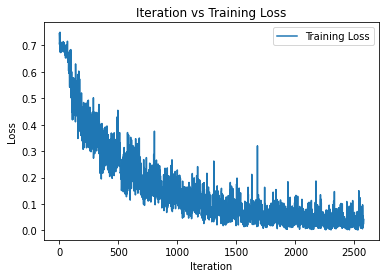

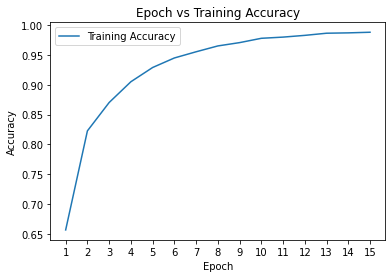

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

## Manual Test
Now, let's have a manual test on this trained model.  
First, you need to input two statements that are similar but one is against common sense. Then, our trained model will predict which of the two statements is against common sense. In this way, we can check the performance of the model.  

To perform a manual test, please run the following code block.

In [ ]:

manual_test = True
count = 1
while(manual_test):
    print("Let's start our manual test.\n")
    time.sleep(0.3)
    
    statement_1 = input("Please input your first statement (e.g. I drink milk.):\n")
    statement_2 = input("Please input your second statement (e.g. Milk drinks me.):\n")

    # Tokenization for two statements
    # inputs = tokenizer(statement_1, statement_2, truncation=True, padding=True, return_tensors="pt").to(device)
    inputs = tokenizer(statement_1, truncation=True, padding=True, return_tensors="pt").to(device)

    # Model makes its prediction
    outputs = model(**inputs)
    prediction = predict(outputs)
    print(prediction)


# **AUTOMATIC TEST**

In [19]:
# Testing
from torch.utils.data import DataLoader

# Load the best-trained model
model.load_state_dict(torch.load(model_params_path))

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

counter = 0
PATH = './generated_sentences.txt'
with open(PATH) as f:
  input_batch_txt = [line.rstrip('\n').replace(',', '').replace('\'','').replace('\xa0', '') for line in f]
  for statement in input_batch_txt:
    # Tokenization for two statements
    # inputs = tokenizer(statement_1, statement_2, truncation=True, padding=True, return_tensors="pt").to(device)
    inputs = tokenizer(statement, truncation=True, padding=True, return_tensors="pt").to(device)

    # Model makes its prediction
    outputs = model(**inputs)
    # prediction = predict(outputs)
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    # print(predictions)
    if predictions==1:
      counter += 1
    else:
      print(probabilities)
      print(statement)

  print("Generated annotations:")
  print(f"Model predicted that {counter}/{len(input_batch_txt)} sentences are common sense.")


tensor([[0.8619, 0.1381]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black person in the suit and suit took the read.
tensor([[0.9829, 0.0171]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black in suits and suits took the bench.
tensor([[0.9961, 0.0039]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black person in the suit took the knife.
tensor([[9.9972e-01, 2.7598e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black person in the suit and notebook took the suit.
tensor([[0.9738, 0.0262]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black person in the suit and notebook took a pocket.
tensor([[0.9465, 0.0535]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black person in the suit and notebook took a reading.
tensor([[0.8889, 0.1111]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black person in the suit and notebook took the bench.
tensor([[9.9908e-01, 9.2086e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The black person in the suit and no

In [57]:
# Testing
from torch.utils.data import DataLoader

# Load the best-trained model
model.load_state_dict(torch.load(model_params_path))

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

counter = 0
correct = 0
count = 0
accuracy = 0


for idx in range(len(test_texts)):
  statement = test_texts.iloc[idx]
  # Tokenization for two statements
  # inputs = tokenizer(statement_1, statement_2, truncation=True, padding=True, return_tensors="pt").to(device)
  inputs = tokenizer(statement, truncation=True, padding=True, return_tensors="pt").to(device)

  # Model makes its prediction
  outputs = model(**inputs)
  probabilities = torch.softmax(outputs["logits"], dim=1)
  predictions = torch.argmax(probabilities, dim=1)

  # count accuracy
  if int(predictions) == 0 and test_labels.iloc[idx] == 0:
    correct += 1
  elif int(predictions) == 1 and test_labels.iloc[idx] == 1:
    correct += 1

count = len(test_texts)
accuracy = correct * 1.0 / count

print("Results on test set of ComVE")
print("Number of total examples: ")
print(count)
print('Accuracy {:.3f}'.format(accuracy))


1778
2000
Accuracy 0.889
